# Análisis de OEE en la Industria del Empaque
## Notebook 2 — Análisis, Visualización y Recomendaciones

Este notebook cubre las últimas tres fases del proceso de análisis de datos:

4. **Analyze** — Cálculos de OEE y análisis de patrones
5. **Share** — Visualizaciones y hallazgos clave
6. **Act** — Conclusiones y recomendaciones

---

## Fase 4 — Analyze (Análisis)

Con los datos ya limpios del Notebook 01, procedemos a realizar los cálculos centrales del análisis.

### 4.1 Carga de datos y preparación

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración visual
sns.set_theme(style='whitegrid')
if not os.path.exists('../visualizaciones'):
    os.makedirs('../visualizaciones')

# Cargar y preparar datos (mismos pasos de limpieza del Notebook 01)
df = pd.read_csv('../datos/raw_data.csv')
df['interval_start'] = pd.to_datetime(df['interval_start'], format='mixed')

traduccion_estados = {
    'idle': 'Inactividad (Idle)',
    'scheduled_downtime': 'Mantenimiento Planeado',
    'performance_loss': 'Pérdida de Rendimiento',
    'downtime': 'Falla de Equipo (Downtime)',
    'production': 'Producción'
}
nombres_equipos = {
    's_1': 'Máquina 1', 's_2': 'Máquina 2', 's_3': 'Máquina 3',
    's_4': 'Máquina 4', 's_5': 'Máquina 5'
}

df['tipo_estado'] = df['type'].map(traduccion_estados).fillna(df['type'])
df['equipo_nombre'] = df['equipment_ID'].map(nombres_equipos).fillna(df['equipment_ID'])
df['fecha'] = df['interval_start'].dt.date

print(f"Dataset cargado: {df.shape[0]:,} registros, {df['equipo_nombre'].nunique()} equipos")
print("Listo para el análisis.")

Dataset cargado: 429,394 registros, 5 equipos
Listo para el análisis.


### 4.2 Análisis de Pareto: causas de tiempo perdido

Aplicamos el **Principio de Pareto** para identificar si unas pocas categorías explican la mayoría del tiempo perdido. Filtramos solo los estados que NO son producción activa.

In [13]:
# Filtrar solo tiempo no productivo
downtime_df = df[df['tipo_estado'] != 'Producción']

# Agrupar por tipo de estado y sumar duración
pareto_data = downtime_df.groupby('tipo_estado')['elapsed'].sum().sort_values(ascending=False)

# Calcular porcentajes
pareto_porcentaje = (pareto_data / pareto_data.sum()) * 100
pareto_acumulado = pareto_porcentaje.cumsum()

# Convertir a horas para mejor comprensión
pareto_horas = pareto_data / 1000 / 3600  # milisegundos → horas

print("--- Desglose de tiempo no productivo ---")
for estado, pct in pareto_porcentaje.items():
    horas = pareto_horas[estado]
    print(f"  {estado}: {pct:.1f}% ({horas:,.0f} horas)")

--- Desglose de tiempo no productivo ---
  Inactividad (Idle): 41.5% (10,266 horas)
  Mantenimiento Planeado: 26.4% (6,534 horas)
  Pérdida de Rendimiento: 19.4% (4,793 horas)
  Falla de Equipo (Downtime): 12.7% (3,147 horas)


### 4.3 Cálculo del OEE por máquina

El **OEE (Overall Equipment Effectiveness)** es el indicador estándar mundial para medir la eficiencia de equipos. Se calcula multiplicando tres componentes:

| Componente | Fórmula | Interpretación |
|-----------|---------|----------------|
| **Disponibilidad** | Tiempo Operativo / (Tiempo Total − Mant. Planeado) | ¿Cuánto tiempo estuvo disponible? |
| **Rendimiento** | Producción real / Producción esperada | ¿A qué velocidad trabajó? |
| **Calidad** | Piezas buenas (`po`) / Piezas totales (`pi`) | ¿Cuántas piezas fueron buenas? |
| **OEE** | Disponibilidad × Rendimiento × Calidad | Eficiencia global |

Un OEE de **85%** o superior se considera **"Clase Mundial"**.

In [14]:
# Calcular OEE para cada máquina
equipos = sorted(df['equipo_nombre'].unique())
oee_data = []

for eq in equipos:
    df_eq = df[df['equipo_nombre'] == eq]
    
    # --- DISPONIBILIDAD ---
    total_time = df_eq['elapsed'].sum()
    scheduled_downtime = df_eq[df_eq['tipo_estado'] == 'Mantenimiento Planeado']['elapsed'].sum()
    planned_production_time = total_time - scheduled_downtime
    operating_time = df_eq[df_eq['tipo_estado'] == 'Producción']['elapsed'].sum()
    availability = operating_time / planned_production_time if planned_production_time > 0 else 0
    
    # --- RENDIMIENTO ---
    total_pi = df_eq['pi'].max() - df_eq['pi'].min()  # Incremento neto del contador
    operating_time_hr = operating_time / 1000 / 3600   # Milisegundos a horas
    max_speed_hr = df_eq['speed'].max()                # Velocidad nominal (máxima registrada)
    expected_pi = operating_time_hr * max_speed_hr
    performance = total_pi / expected_pi if expected_pi > 0 else 0
    if performance > 1.0:
        performance = 1.0  # Limitar al 100% (anomalías de contadores)
    
    # --- CALIDAD ---
    total_po = df_eq['po'].max() - df_eq['po'].min()   # Piezas buenas de salida
    quality = total_po / total_pi if total_pi > 0 else 0
    
    # --- OEE ---
    oee = availability * performance * quality
    
    oee_data.append({
        'Equipo': eq,
        'Disponibilidad (%)': round(availability * 100, 2),
        'Rendimiento (%)': round(performance * 100, 2),
        'Calidad (%)': round(quality * 100, 2),
        'OEE (%)': round(oee * 100, 2)
    })

oee_df = pd.DataFrame(oee_data)
print("--- Tabla de OEE por Máquina ---")
display(oee_df)

--- Tabla de OEE por Máquina ---


,Equipo,Disponibilidad (%),Rendimiento (%),Calidad (%),OEE (%)
0,Máquina 1,64.71,100.00,99.59,64.45
1,Máquina 2,32.58,100.00,100.17,32.64
2,Máquina 3,44.69,100.00,99.76,44.59
3,Máquina 4,44.00,4.58,99.16,2.00
4,Máquina 5,53.38,100.00,83.12,44.37


In [15]:
# Promedios generales de la planta
print("--- PROMEDIOS GENERALES DE LA PLANTA ---")
promedios = oee_df[['Disponibilidad (%)', 'Rendimiento (%)', 'Calidad (%)', 'OEE (%)']].mean()
for metrica, valor in promedios.items():
    print(f"  {metrica}: {valor:.2f}%")

--- PROMEDIOS GENERALES DE LA PLANTA ---
  Disponibilidad (%): 47.87%
  Rendimiento (%): 80.92%
  Calidad (%): 96.36%
  OEE (%): 37.61%


### 4.4 Análisis temporal: producción diaria

Analizamos cómo varía la producción a lo largo del tiempo para detectar patrones, tendencias o anomalías.

In [16]:
# Horas de producción por día
produccion_diaria = df[df['tipo_estado'] == 'Producción'].groupby('fecha')['elapsed'].sum() / 1000 / 3600

print(f"Producción diaria promedio: {produccion_diaria.mean():.1f} horas-máquina")
print(f"Día de mayor producción: {produccion_diaria.idxmax()} ({produccion_diaria.max():.1f} hrs)")
print(f"Día de menor producción: {produccion_diaria.idxmin()} ({produccion_diaria.min():.1f} hrs)")

Producción diaria promedio: 26.7 horas-máquina
Día de mayor producción: 2021-11-18 (56.4 hrs)
Día de menor producción: 2021-01-03 (0.0 hrs)


### 4.5 Producción acumulada por equipo

In [17]:
# Producción acumulada (output neto) por equipo
produccion_equipos = df.groupby('equipo_nombre').apply(
    lambda x: x['po'].max() - x['po'].min()
).sort_values(ascending=False)

print("--- Producción neta por equipo (piezas output) ---")
for eq, prod in produccion_equipos.items():
    print(f"  {eq}: {prod:,.0f} piezas")

--- Producción neta por equipo (piezas output) ---
  Máquina 2: 339,148,800 piezas
  Máquina 5: 42,178,715 piezas
  Máquina 1: 39,327,038 piezas
  Máquina 3: 15,757,335 piezas
  Máquina 4: 796,267 piezas


C:\Users\Diego\AppData\Local\Temp\ipykernel_14740\1659680458.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  produccion_equipos = df.groupby('equipo_nombre').apply(


---
## Fase 5 — Share (Visualizaciones y Hallazgos)

A continuación se presentan las visualizaciones que comunican los hallazgos principales del análisis.

### 5.1 Gráfico de Pareto: causas de tiempo perdido

Este gráfico muestra qué tipos de parada representan la mayor parte del tiempo no productivo. La línea roja indica el porcentaje acumulado.

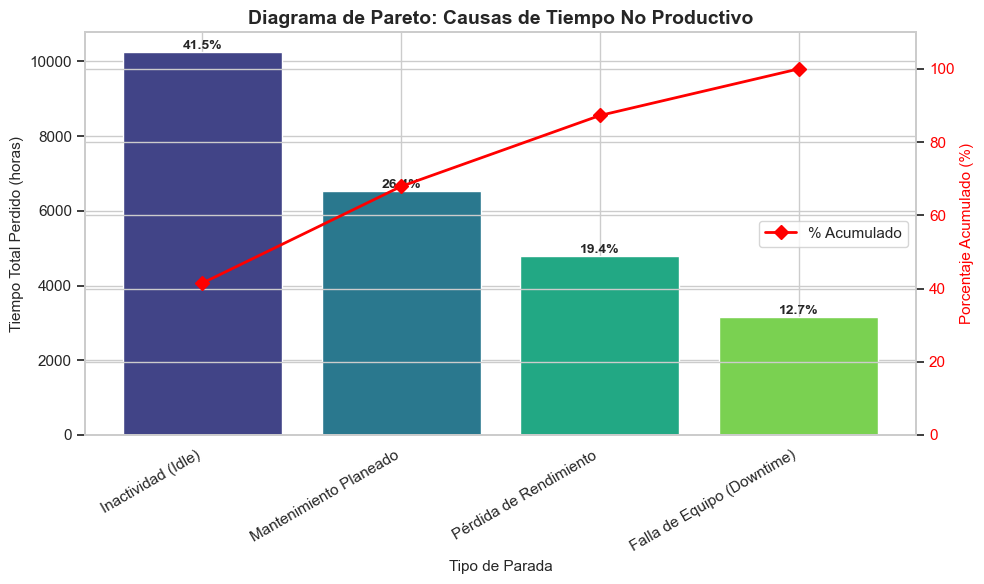

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras de tiempo perdido (en horas para mejor lectura)
colores = sns.color_palette('viridis', len(pareto_horas))
barras = ax1.bar(range(len(pareto_horas)), pareto_horas.values, color=colores)
ax1.set_xticks(range(len(pareto_horas)))
ax1.set_xticklabels(pareto_horas.index, rotation=30, ha='right')
ax1.set_ylabel('Tiempo Total Perdido (horas)', fontsize=11)
ax1.set_xlabel('Tipo de Parada', fontsize=11)
ax1.set_title('Diagrama de Pareto: Causas de Tiempo No Productivo', fontsize=14, fontweight='bold')

# Agregar etiquetas de porcentaje sobre cada barra
for i, (barra, pct) in enumerate(zip(barras, pareto_porcentaje.values)):
    ax1.text(barra.get_x() + barra.get_width()/2, barra.get_height(),
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Línea de porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(range(len(pareto_acumulado)), pareto_acumulado.values, 
         color='red', marker='D', ms=7, linewidth=2, label='% Acumulado')
ax2.set_ylabel('Porcentaje Acumulado (%)', fontsize=11, color='red')
ax2.set_ylim(0, 110)
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='center right')

plt.tight_layout()
plt.savefig('../visualizaciones/pareto_downtime.png', dpi=150, bbox_inches='tight')
plt.show()

**Hallazgo**: La *Inactividad (Idle)* y el *Mantenimiento Planeado* juntos representan casi el **70%** de todo el tiempo no productivo. Esto indica que atacar estos dos factores tendría el mayor impacto.

### 5.2 Desglose de OEE por máquina

Este gráfico compara las tres métricas del OEE y el resultado final para cada máquina, con una línea de referencia en 85% (meta "Clase Mundial").

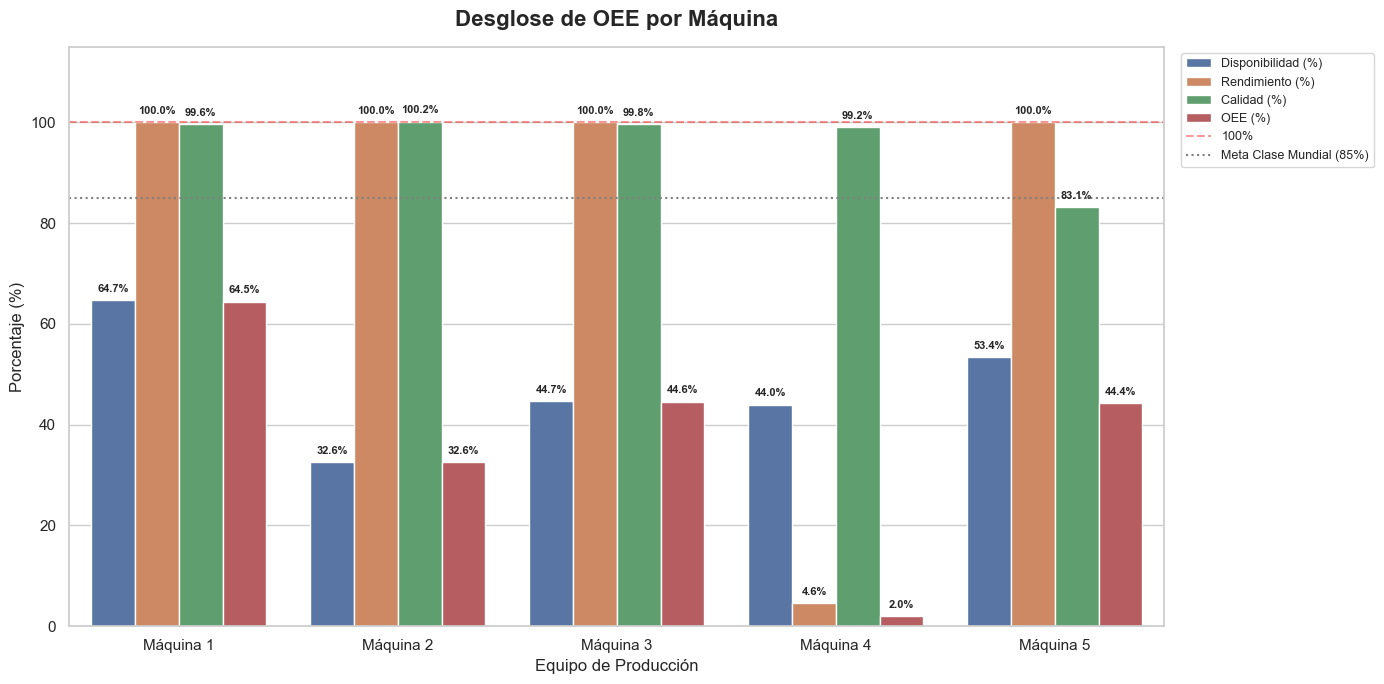

In [19]:
# Preparar datos para gráfico agrupado
oee_melted = pd.melt(
    oee_df, id_vars=['Equipo'], 
    value_vars=['Disponibilidad (%)', 'Rendimiento (%)', 'Calidad (%)', 'OEE (%)'],
    var_name='Métrica', value_name='Porcentaje'
)

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=oee_melted, x='Equipo', y='Porcentaje', hue='Métrica', palette='deep')

plt.title('Desglose de OEE por Máquina', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Equipo de Producción', fontsize=12)
plt.ylim(0, 115)

# Líneas de referencia
plt.axhline(y=100, color='red', linestyle='--', alpha=0.4, label='100%')
plt.axhline(y=85, color='gray', linestyle=':', linewidth=1.5, label='Meta Clase Mundial (85%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Etiquetas de valor sobre las barras
for p in ax.patches:
    valor = p.get_height()
    if valor > 0:
        ax.annotate(f'{valor:.1f}%',
                    (p.get_x() + p.get_width() / 2., valor),
                    ha='center', va='center', xytext=(0, 8),
                    textcoords='offset points', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizaciones/oee_componentes.png', dpi=150, bbox_inches='tight')
plt.show()

**Hallazgo**: La **Calidad** es consistentemente alta en todas las máquinas (por encima del 90%), lo cual es positivo. Sin embargo, la **Disponibilidad** es la métrica que más reduce el OEE final, confirmando que el tiempo de inactividad es el principal problema.

### 5.3 Producción total por equipo

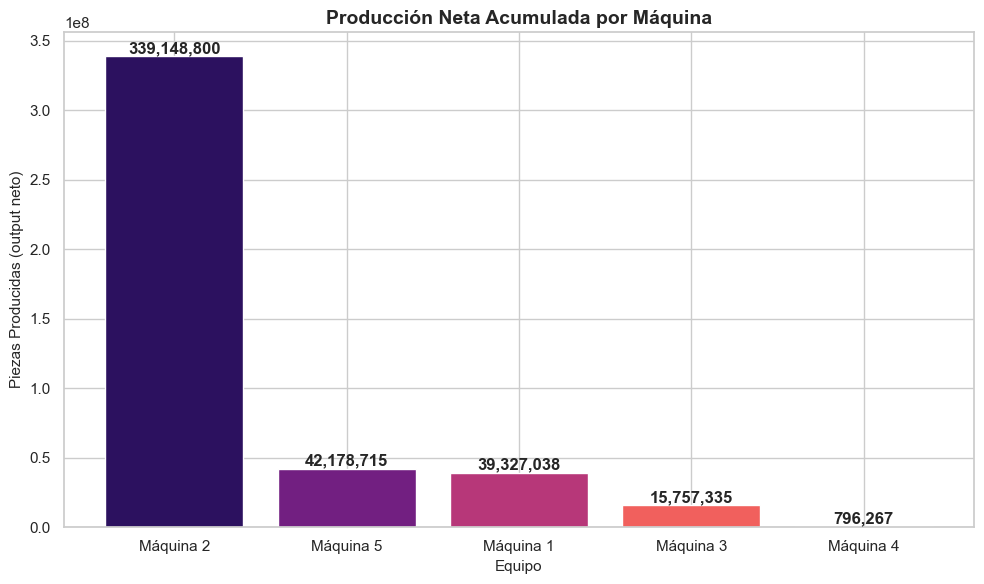

In [20]:
plt.figure(figsize=(10, 6))
colores_eq = sns.color_palette('magma', len(produccion_equipos))
barras = plt.bar(produccion_equipos.index, produccion_equipos.values, color=colores_eq)

# Etiquetas de valor
for barra in barras:
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height(),
             f'{barra.get_height():,.0f}', ha='center', va='bottom', fontweight='bold')

plt.title('Producción Neta Acumulada por Máquina', fontsize=14, fontweight='bold')
plt.ylabel('Piezas Producidas (output neto)', fontsize=11)
plt.xlabel('Equipo', fontsize=11)
plt.tight_layout()
plt.savefig('../visualizaciones/produccion_equipos.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Serie temporal: horas de producción diarias

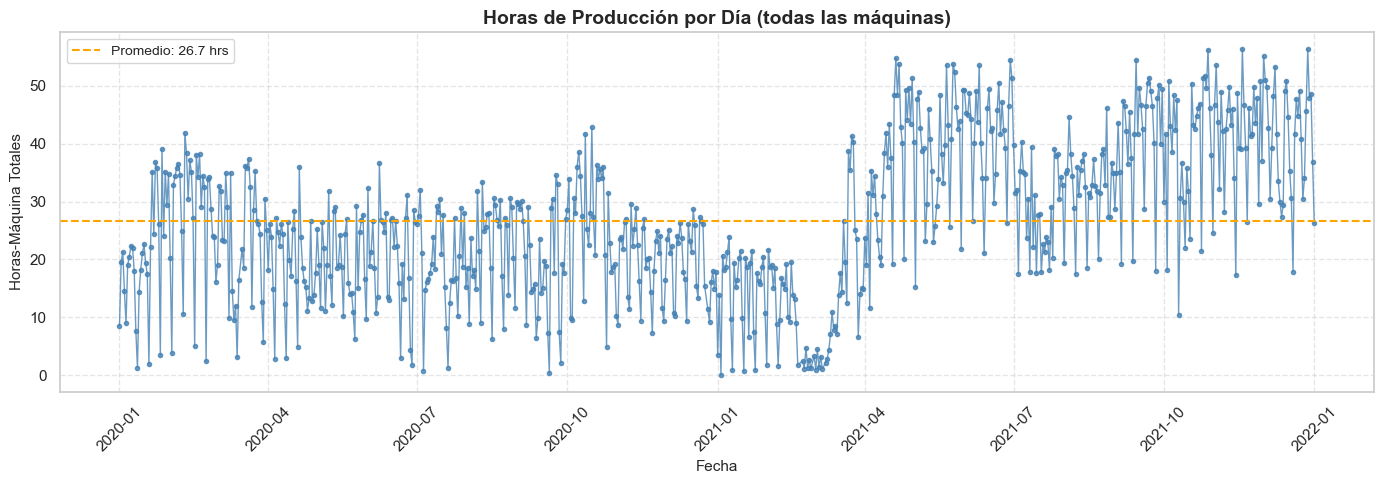

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(produccion_diaria.index, produccion_diaria.values, 
         marker='o', markersize=3, color='steelblue', linewidth=1, alpha=0.8)

# Línea de promedio
promedio = produccion_diaria.mean()
plt.axhline(y=promedio, color='orange', linestyle='--', linewidth=1.5,
            label=f'Promedio: {promedio:.1f} hrs')

plt.title('Horas de Producción por Día (todas las máquinas)', fontsize=14, fontweight='bold')
plt.ylabel('Horas-Máquina Totales', fontsize=11)
plt.xlabel('Fecha', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('../visualizaciones/produccion_temporal.png', dpi=150, bbox_inches='tight')
plt.show()

**Hallazgo**: La producción diaria muestra alta variabilidad. Hay días con picos significativos y otros con caídas drásticas, lo cual sugiere irregularidades operativas (posibles paradas completas de planta, fines de semana, o problemas de suministro).

### 5.5 Tabla resumen final

In [22]:
# Tabla resumen con formato
print("=" * 60)
print("     RESUMEN DE OEE POR MÁQUINA")
print("=" * 60)
display(oee_df.style.format({
    'Disponibilidad (%)': '{:.2f}%',
    'Rendimiento (%)': '{:.2f}%',
    'Calidad (%)': '{:.2f}%',
    'OEE (%)': '{:.2f}%'
}).set_properties(**{'text-align': 'center'}))

print(f"\nOEE Promedio de la planta: {oee_df['OEE (%)'].mean():.2f}%")
print(f"Meta Clase Mundial: 85%")

     RESUMEN DE OEE POR MÁQUINA


,Equipo,Disponibilidad (%),Rendimiento (%),Calidad (%),OEE (%)
0,Máquina 1,64.71%,100.00%,99.59%,64.45%
1,Máquina 2,32.58%,100.00%,100.17%,32.64%
2,Máquina 3,44.69%,100.00%,99.76%,44.59%
3,Máquina 4,44.00%,4.58%,99.16%,2.00%
4,Máquina 5,53.38%,100.00%,83.12%,44.37%



OEE Promedio de la planta: 37.61%
Meta Clase Mundial: 85%


---
## Fase 6 — Act (Conclusiones y Recomendaciones)

Basándonos en todo el análisis anterior, estas son las conclusiones principales y las acciones recomendadas.

### Conclusiones principales

1. **La Inactividad (Idle) es la mayor fuente de pérdida**: Representa aproximadamente el **41%** del tiempo no productivo. Al ser tiempo "no clasificado", es probable que incluya esperas por material, cambios de turno o paradas no documentadas adecuadamente.

2. **El Mantenimiento Planeado consume demasiado tiempo**: Con un **~26%** del tiempo de parada, sugiere que las rutinas de mantenimiento preventivo podrían no estar optimizadas o que se realizan durante horarios de alta demanda.

3. **La Calidad es un punto fuerte**: Todas las máquinas mantienen tasas de calidad superiores al 90%, lo que indica que el proceso de empaque en sí funciona bien cuando la máquina está operando.

4. **La Disponibilidad es el cuello de botella del OEE**: Esta métrica es la que más arrastra hacia abajo el OEE final, demostrando que el problema principal no es la velocidad ni la calidad, sino el tiempo que las máquinas están detenidas.

### Recomendaciones accionables

| # | Recomendación | Impacto esperado | Responsable sugerido |
|---|--------------|------------------|---------------------|
| 1 | **Investigar y clasificar el tiempo "Idle"**: Implementar subcategorías (espera de material, cambio de turno, configuración, sin clasificar) para entender qué está causando este tiempo muerto | Alto — podría reducir el 41% de pérdidas | Supervisores de turno |
| 2 | **Optimizar el calendario de mantenimiento**: Reprogramar mantenimientos preventivos a horarios de menor demanda productiva y evaluar si la frecuencia actual es excesiva | Medio — podría reducir el 26% de paradas planeadas | Equipo de mantenimiento |
| 3 | **Monitorear patrones temporales**: Usar la serie de tiempo de producción diaria para identificar días de baja producción recurrente y correlacionar con causas externas | Medio — detectar cuellos de botella sistemáticos | Gerencia de operaciones |

### Próximos pasos sugeridos
- **Dashboard interactivo**: Crear un panel en Looker Studio o Tableau conectado a estos datos para monitoreo continuo.
- **Análisis predictivo**: Usar el archivo `sequences_1h_data.csv` para entrenar un modelo de Machine Learning que anticipe fallos inminentes.
- **Estandarizar registro de paradas**: Mejorar la categorización de eventos "idle" en el sistema de telemetría para obtener mejor visibilidad.